In [1]:
# ===============================================
# Import Libraries
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# ===============================================
# Dataload
# ===============================================
df = pd.read_csv("heart.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
# ===============================================
# 3. Basic Exploration
# ===============================================
print(df.shape)
df.info()
df.describe()
df.isnull().sum()



(1025, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [4]:
# ===============================================
# 4. Train–Test Split
# ===============================================

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
# ===============================================
# 5. Feature Scaling
# ===============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# ===============================================
# 6. Define Models
# ===============================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False
    )
}


In [7]:
# ===============================================
# 7. Evaluation Function
# ===============================================

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    return {
        "Accuracy": accuracy_score(y_test, preds),
        "AUC": roc_auc_score(y_test, probs),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds),
        "MCC": matthews_corrcoef(y_test, preds)
    }


In [8]:
# ===============================================
# 8. Train & Evaluate All Models
# ===============================================

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    metrics = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[name] = metrics

results_df = pd.DataFrame(results).T
results_df


Training Logistic Regression...
Training Decision Tree...
Training KNN...
Training Naive Bayes...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:57:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,AUC,Precision,Recall,F1 Score,MCC
Logistic Regression,0.809756,0.929810,0.761905,0.914286,0.831169,0.630908
Decision Tree,0.985366,0.985714,1.000000,0.971429,0.985507,0.971151
KNN,0.863415,0.962905,0.873786,0.857143,0.865385,0.726935
Naive Bayes,0.829268,0.904286,0.807018,0.876190,0.840183,0.660163
Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


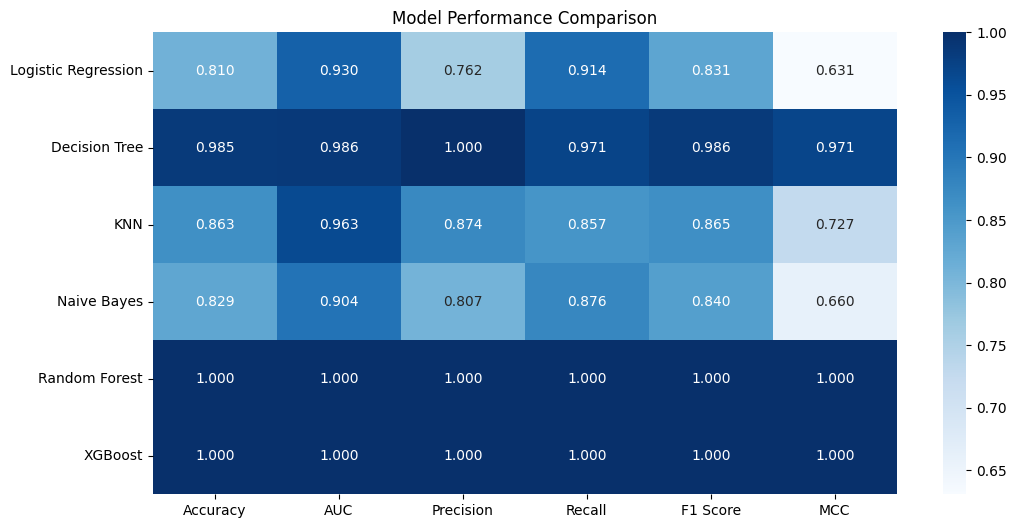

In [9]:
# ===============================================
# 9. Visualize Comparison
# ===============================================

plt.figure(figsize=(12,6))
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Performance Comparison")
plt.show()


In [10]:
# ===============================================
# 10. Save Best Model (for Streamlit)
# ===============================================
import joblib

best_model_name = results_df["AUC"].idxmax()
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Saved:", best_model_name)


Saved: Random Forest
